In [ ]:
import pandas as pd
data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

In [ ]:
print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


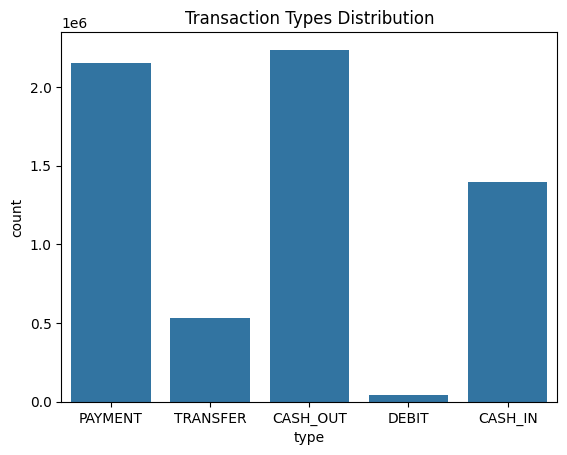

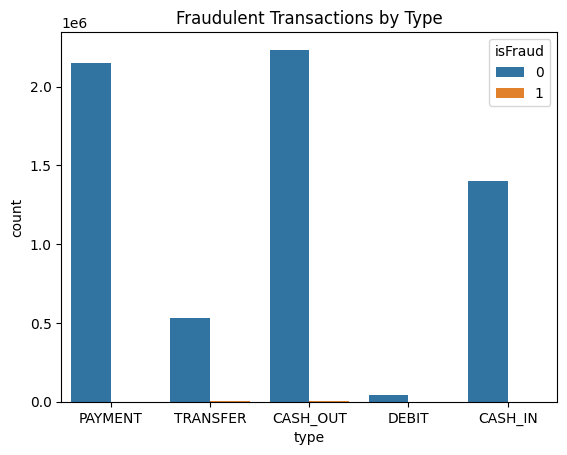

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of transaction types
sns.countplot(x='type', data=data)
plt.title('Transaction Types Distribution')
plt.show()

# Fraud distribution by transaction type
sns.countplot(x='type', hue='isFraud', data=data)
plt.title('Fraudulent Transactions by Type')
plt.show()

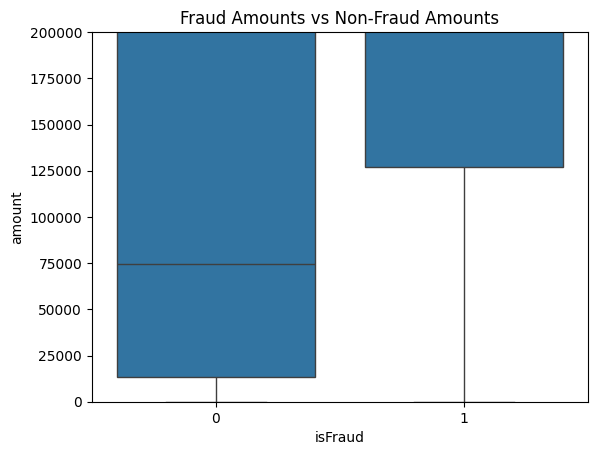

In [ ]:
# Fraud amounts vs. non-fraud amounts
sns.boxplot(x='isFraud', y='amount', data=data)
plt.ylim(0, 200000)  # Set limits to focus on typical values
plt.title('Fraud Amounts vs Non-Fraud Amounts')
plt.show()


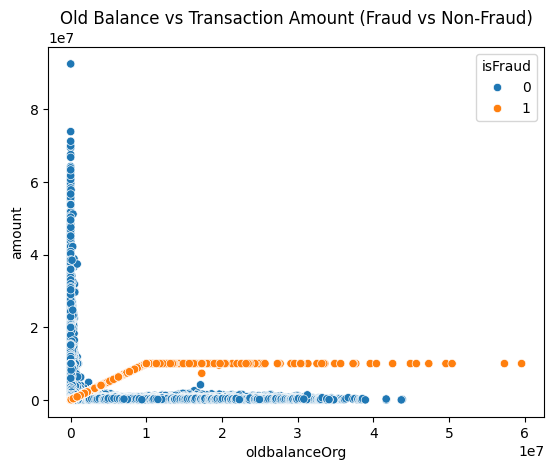

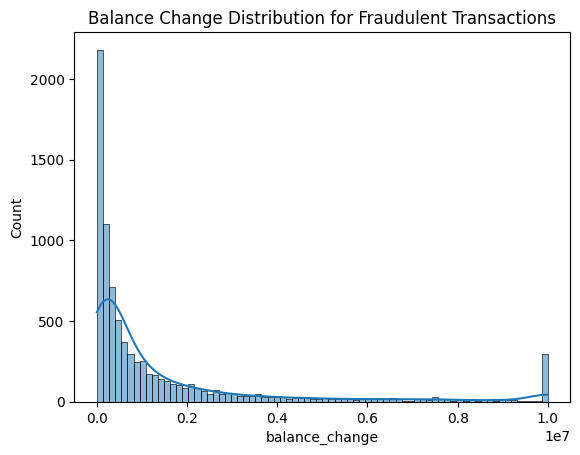

In [ ]:
# Original balance vs. transaction amount
sns.scatterplot(x='oldbalanceOrg', y='amount', hue='isFraud', data=data)
plt.title('Old Balance vs Transaction Amount (Fraud vs Non-Fraud)')
plt.show()

# Check consistency in balance changes
data['balance_change'] = data['oldbalanceOrg'] - data['newbalanceOrig']
sns.histplot(data[data['isFraud'] == 1]['balance_change'], kde=True)
plt.title('Balance Change Distribution for Fraudulent Transactions')
plt.show()


In [ ]:
data['oldbalanceDest'] = data['oldbalanceDest'].fillna(0)
data['newbalanceDest'] = data['newbalanceDest'].fillna(0)
# data cleaning


In [ ]:
Q1 = data['amount'].quantile(0.25)
Q3 = data['amount'].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data['amount'] < (Q1 - 1.5 * IQR)) | (data['amount'] > (Q3 + 1.5 * IQR)))]
# remove outlier

In [ ]:
data = data.drop(['nameOrig', 'nameDest'], axis=1)
# Drop nameOrig and nameDest since they are identifiers and do not contribute to predictions.

In [ ]:
data['balance_diff'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['transaction_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1)  # Avoid division by zero
# create new features

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the features and target
X = data[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = data['isFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a column transformer to apply OneHotEncoder only to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['type']),  # Only apply one-hot encoding to 'type' column
        ('num', 'passthrough', ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])
    ])

# Create a pipeline that first preprocesses the data and then fits a RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Split the dataset into training and test sets.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type']),
                                                 ('num', 'passthrough',
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1806062
           1       0.93      0.59      0.72      1301

    accuracy                           1.00   1807363
   macro avg       0.97      0.79      0.86   1807363
weighted avg       1.00      1.00      1.00   1807363

ROC AUC Score: 0.9913283718507995


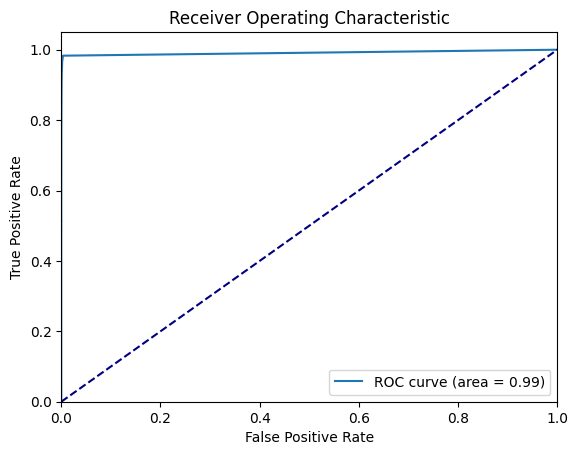

In [ ]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions using the pipeline
y_pred = pipeline.predict(X_test)

# Get the predicted probabilities
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Now you can evaluate the model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Print classification report
print(classification_report(y_test, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



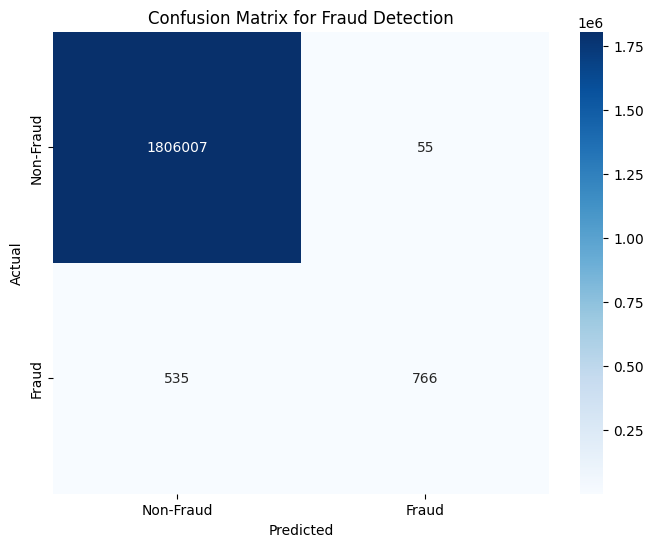

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Fraud Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data is preprocessed (missing values handled, features selected)

# Label Encoding for the 'type' column (categorical column)
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

# Split data into features and target variable
X = data.drop(columns=['isFraud'])
y = data['isFraud']

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)

# Predict on the test data
y_pred = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204029
           1       0.97      0.99      0.98       880

    accuracy                           1.00   1204909
   macro avg       0.99      1.00      0.99   1204909
weighted avg       1.00      1.00      1.00   1204909

ROC AUC Score: 0.9971478785545712


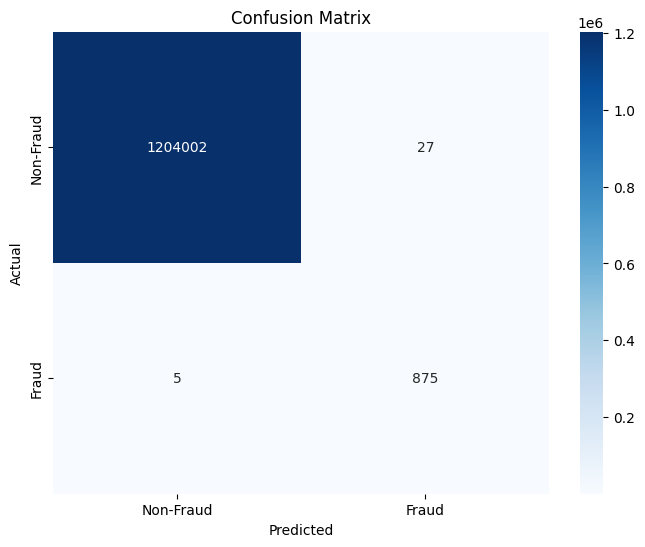

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()